In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# define the microlens

# =========
# distances
# =========

d_l = 4000  # distance of the lens in pc
d_s = 8000  # distance of the source in pc

# ===========
# lens
# ===========

M0 = 0.01  # mass of the main lens in units of M_sol

# ===========
# source size
# ===========

diameter_s = 1  # size of the radius of the source star in units of the solar radius

In [3]:
# compute lensing properties
from lenstronomy.Cosmo.micro_lensing import einstein_radius, source_size

theta_E = einstein_radius(M0, d_l, d_s)
print(theta_E, 'Einstein radius [arc seconds]')

size_s = source_size(diameter_s, d_s)
print(size_s, 'source size in arc seconds')

0.00010090910723578977 Einstein radius [arc seconds]
1.163118159836867e-06 source size in arc seconds


In [4]:
# compute ray-tracing grid

grid_scale = size_s / 10 # ten times the source size resolution
grid_width = theta_E * 4
num_pix = int(grid_width / grid_scale)
print(num_pix)

from lenstronomy.Util import util
x, y = util.make_grid(numPix=num_pix, deltapix=grid_scale)

3470


In [5]:
# map image to source plane
from lenstronomy.LensModel.lens_model import LensModel
lens = LensModel(lens_model_list=['POINT_MASS', 'HESSIAN'])
kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}, {"f_xx": 0, "f_yy": 0, "f_xy": 0, "f_yx": 0, "ra_0": 0, "dec_0": 0}]
beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)

# compute surface brightness
from lenstronomy.LightModel.light_model import LightModel
light = LightModel(light_model_list=['ELLIPSOID'])
kwargs_light = [{'amp': 1, 'radius': size_s/2 * 10, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]

unlensed_surface_brightness = light.surface_brightness(x, y, kwargs_light)
lensed_surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)
total_unlensed_surface_brightness = np.sum(unlensed_surface_brightness)

unlensed_image = util.array2image(unlensed_surface_brightness)
lensed_image = util.array2image(lensed_surface_brightness)

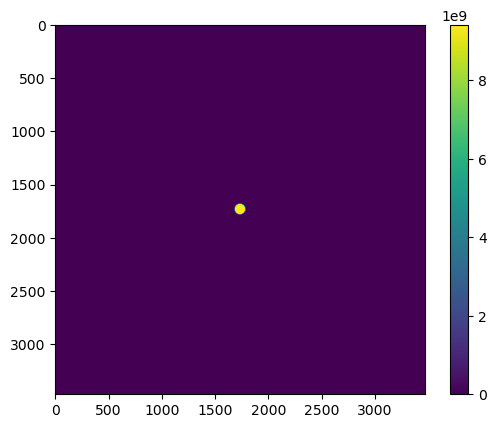

In [6]:
# display the unlensed image
plt.imshow(unlensed_image)
plt.colorbar()
plt.show()

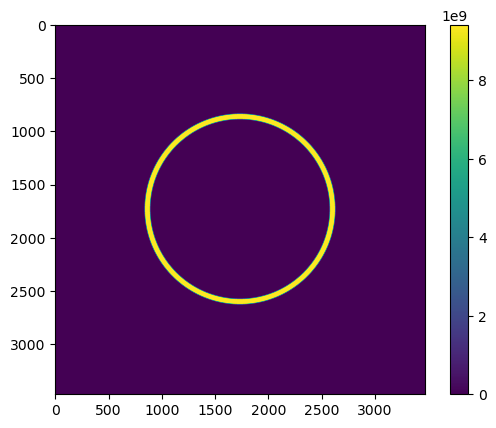

In [8]:
# display the lensed image
plt.imshow(lensed_image)
plt.colorbar()
plt.show()

Our first task is to display the above image in physical units. Currently, the axes are numbered by pixels, and we'd like to have them numbered in arcseconds instead.

In [ ]:
step = (max(beta_x) - min(beta_x))/num_pix
i = 0
center = min(beta_x)
x_centers = np.zeros(num_pix)
while i < num_pix:
    x_centers[i] = center
    center += step
    i += 1

Say the initial position is $(x_o, y_o)$ and the initial velocity is $v_0$, directed at an angle $\theta$. Then $x = x_0 + v_{0x}t$ and $y = y_0 + v_{0y}t$. We can eliminate the parameter to obtain $t = \frac{x - x_0}{v_{0x}}$, so that $y = y_0 + v_{0y}\left(\frac{x - x_0}{v_{0x}}\right) = y_0 + \tan \theta(x-x_0)$. For now, let's work in multiples of the Einstein radius.

In [9]:
def trajectory(x_0, y_0, v_0, theta, simulation_time, no_steps):
    """Right now, everything is in arbitrary units."""
    time_step = simulation_time / no_steps
    theta = theta * np.pi / 180
    v_0x = v_0 * np.cos(theta)
    v_0y = v_0 * np.sin(theta)
    x_trajectory = np.linspace(x_0, v_0x * simulation_time, no_steps + 1)
    y_trajectory = np.linspace(y_0, v_0y * simulation_time, no_steps + 1)
    return x_trajectory, y_trajectory

In [29]:
tra = trajectory(-0.5*grid_width, 0, theta_E, 0, 1, 50)

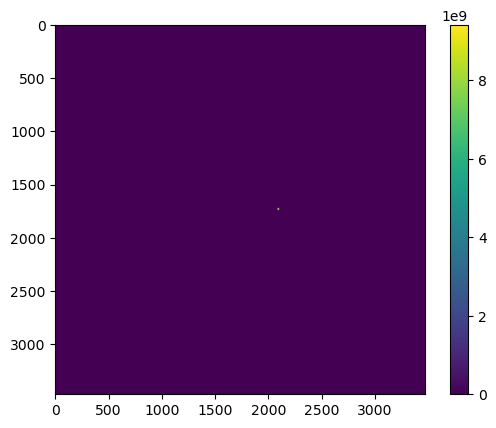

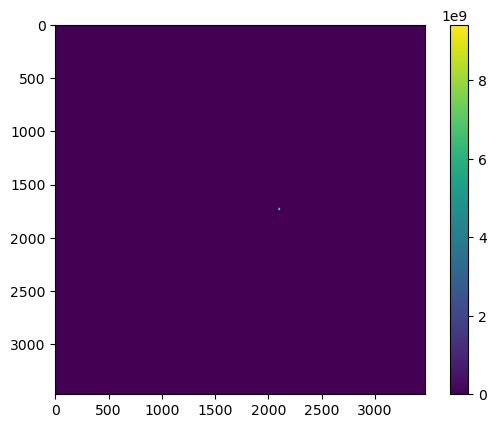

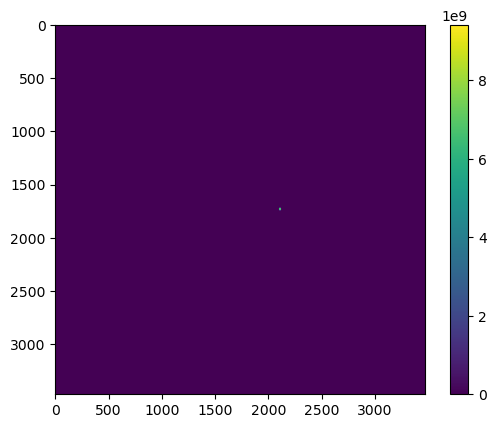

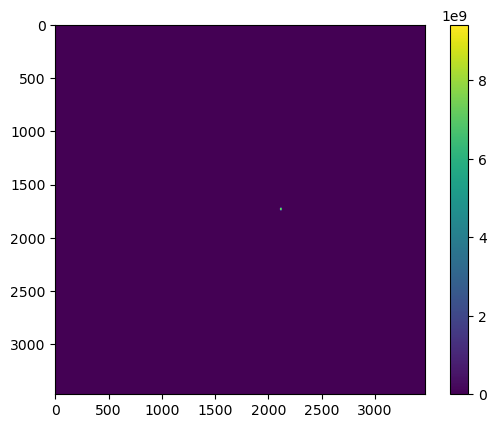

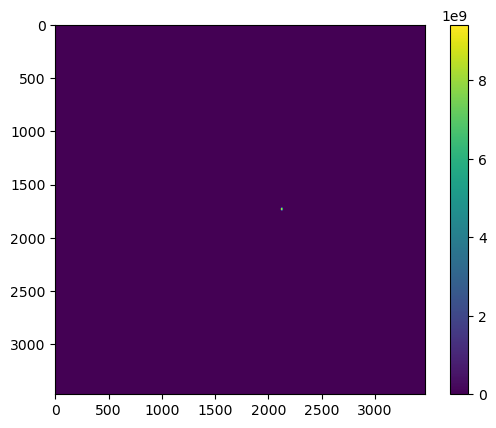

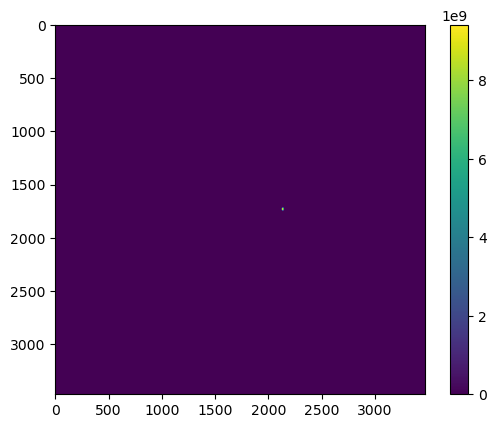

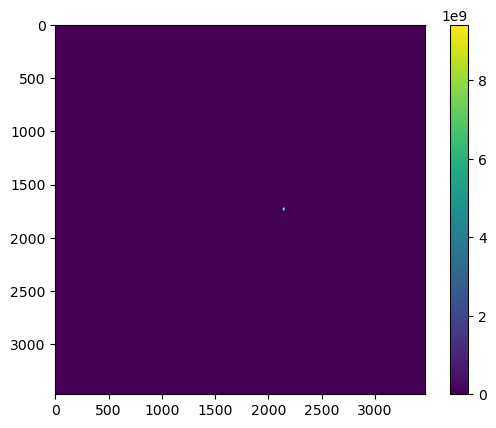

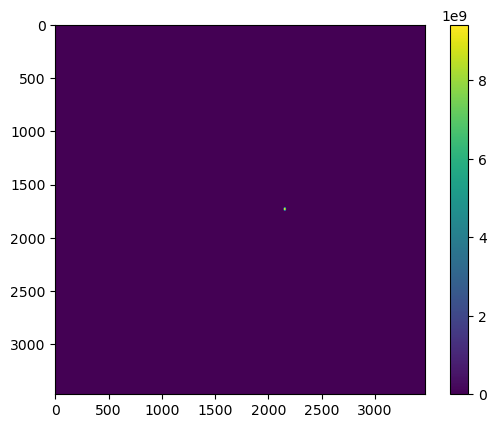

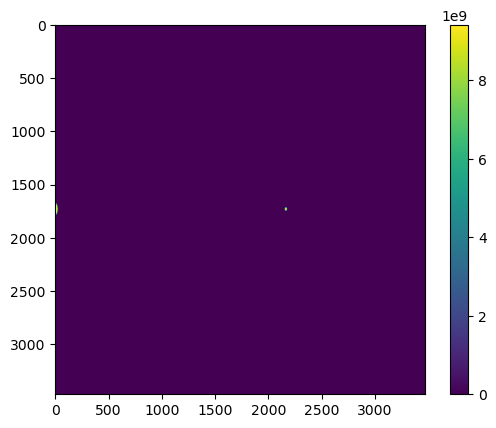

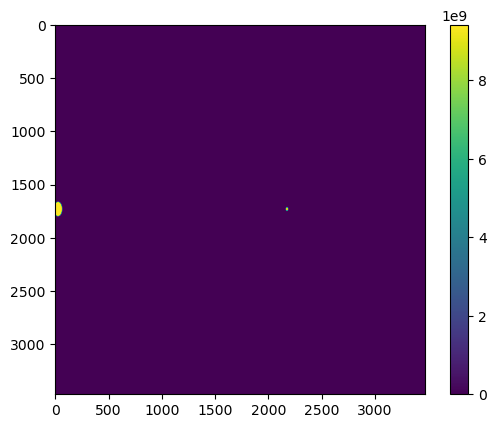

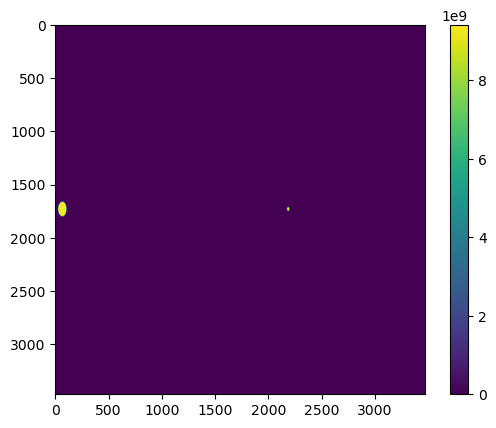

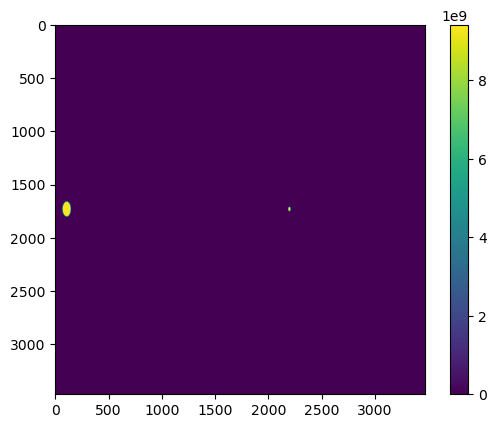

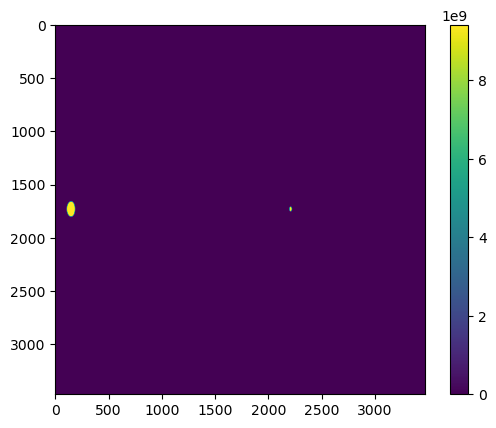

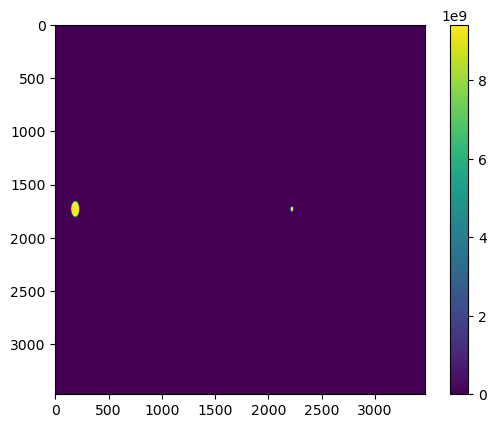

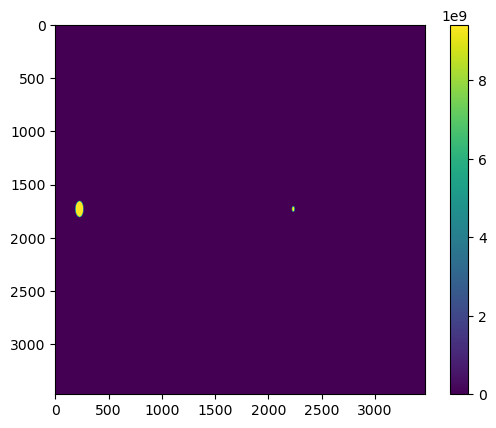

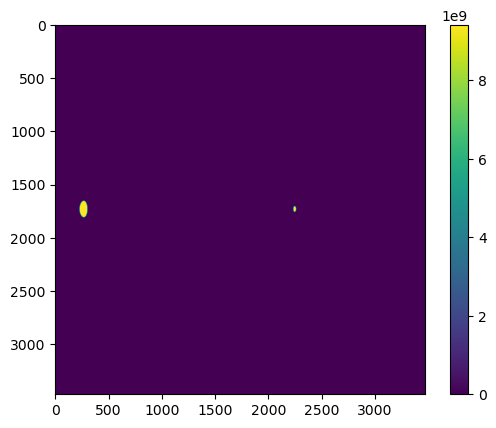

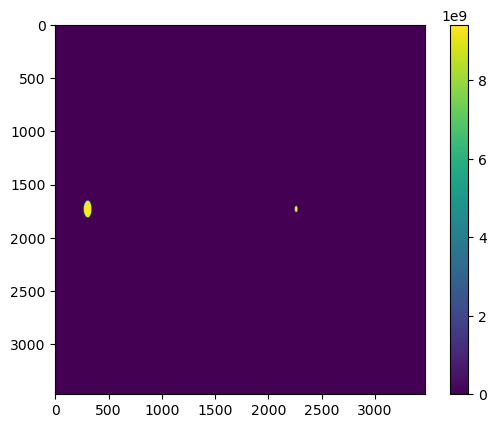

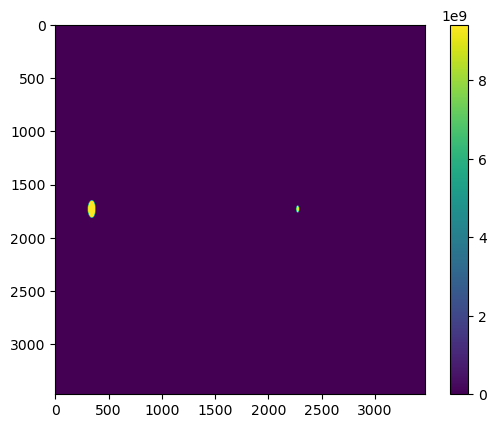

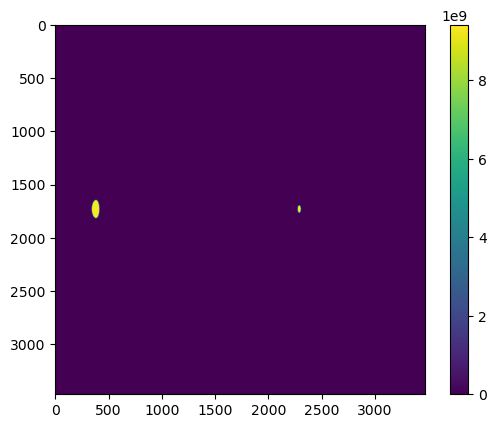

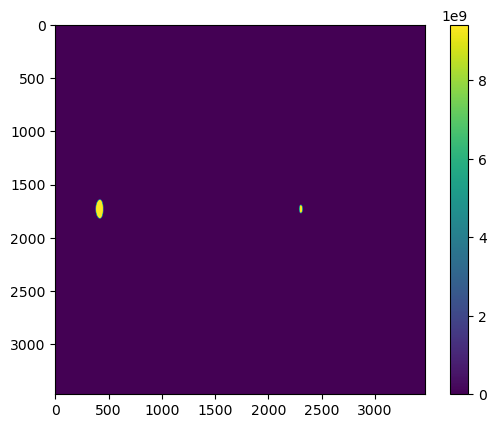

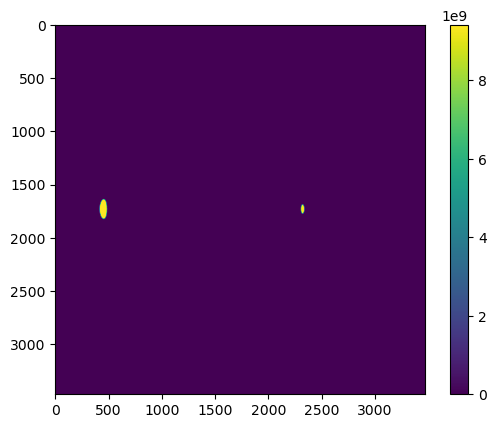

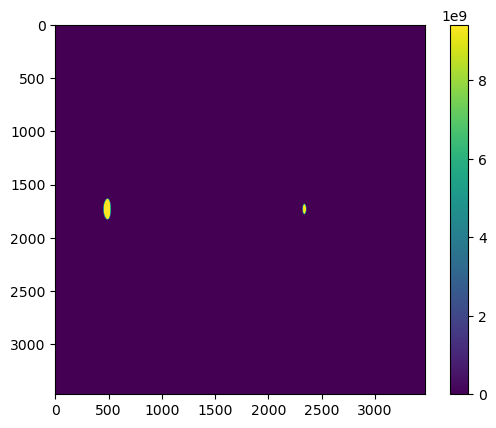

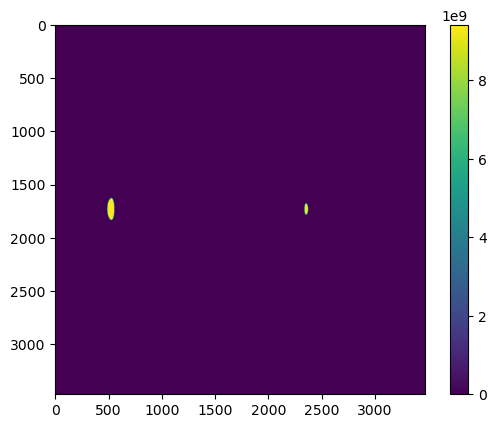

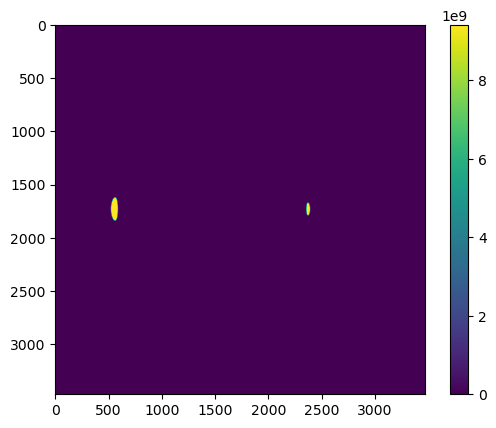

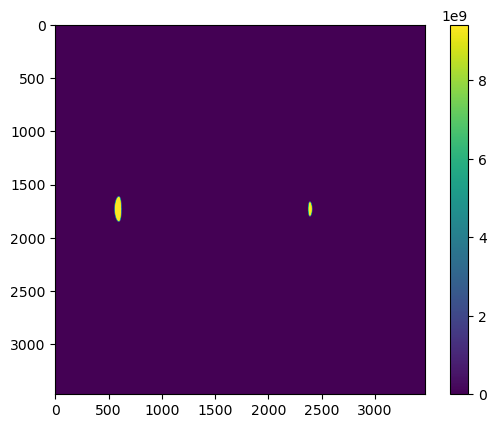

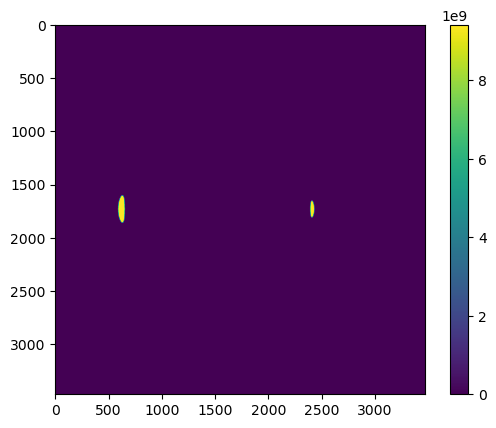

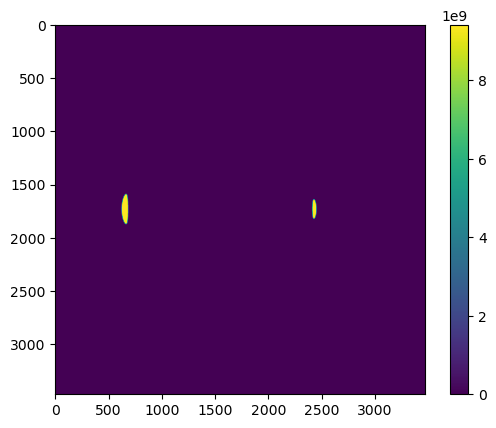

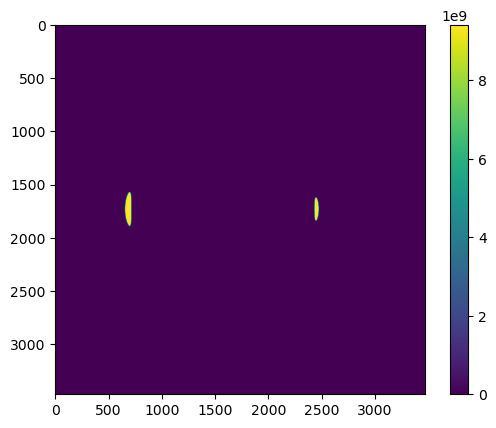

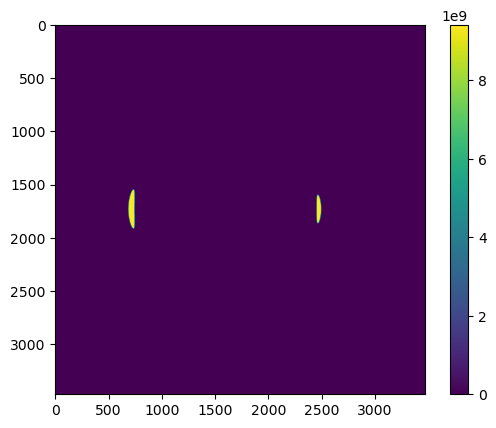

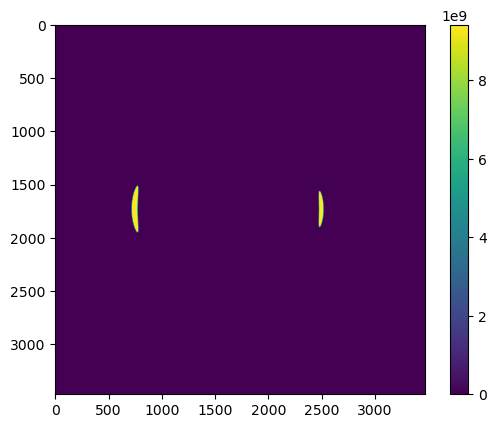

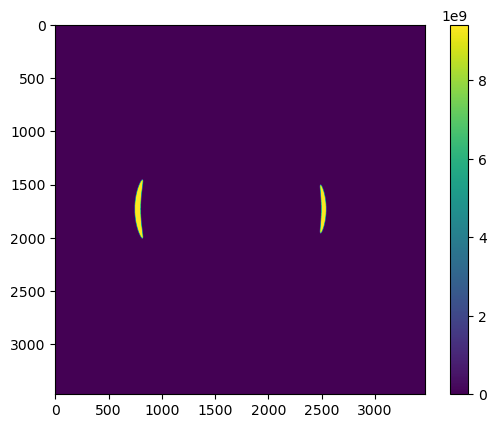

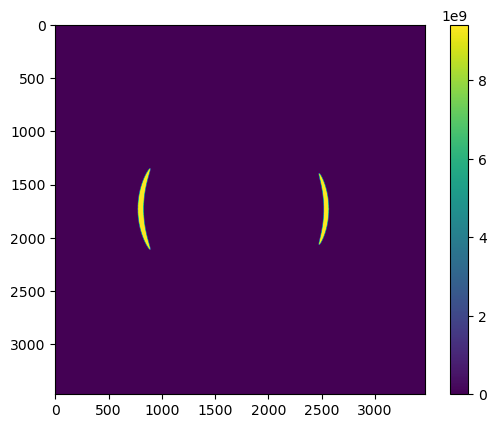

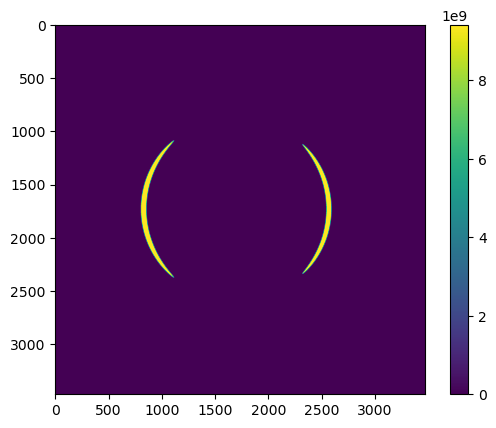

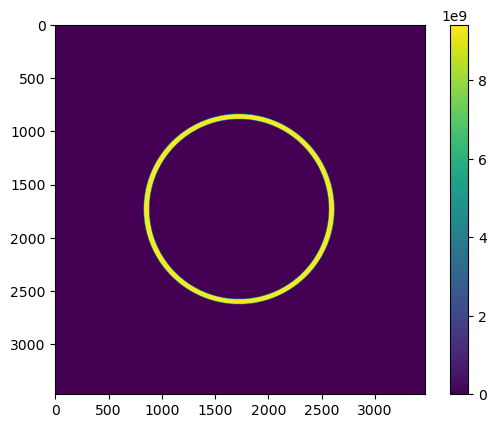

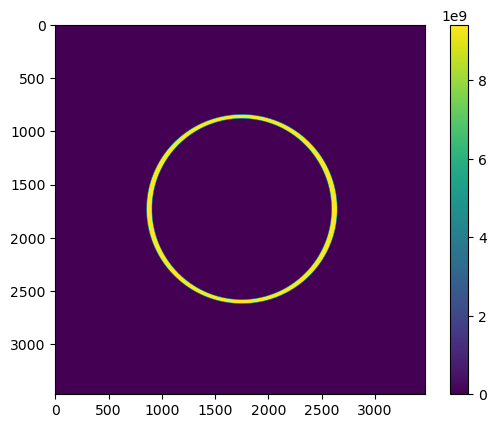

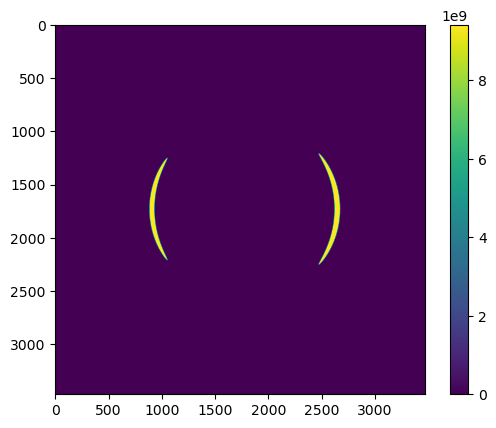

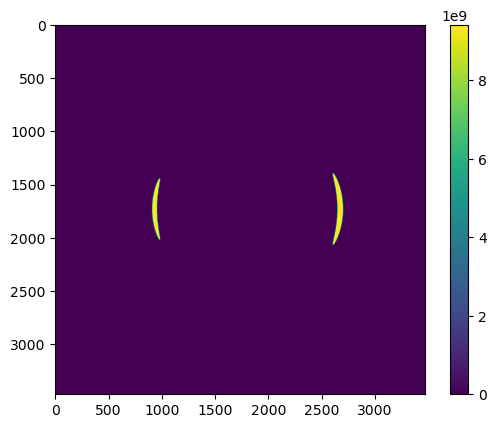

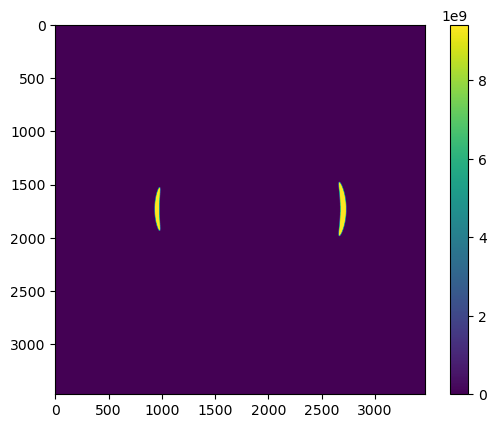

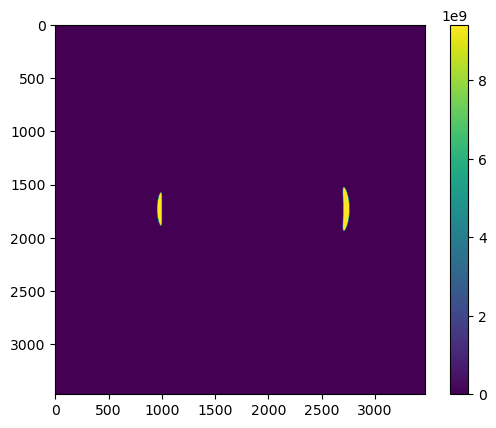

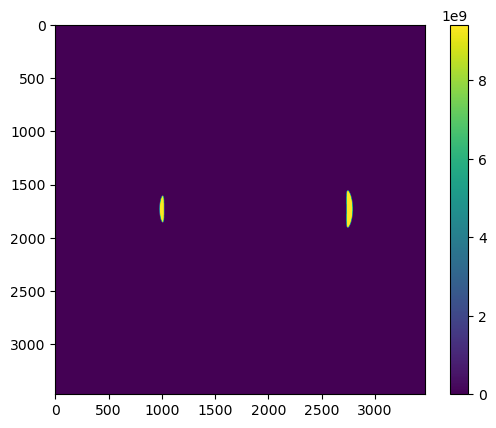

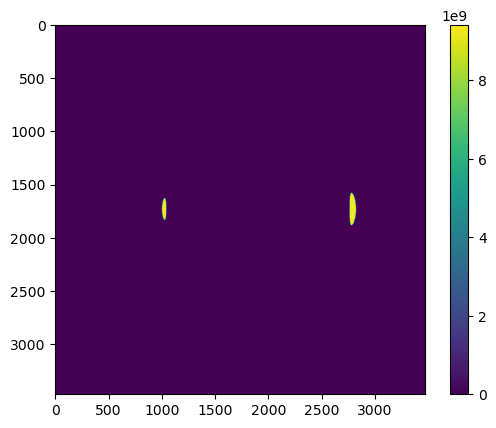

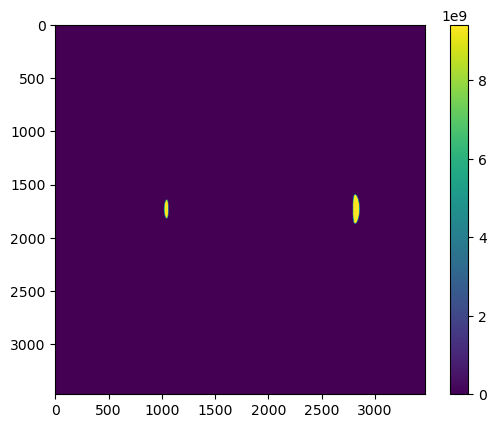

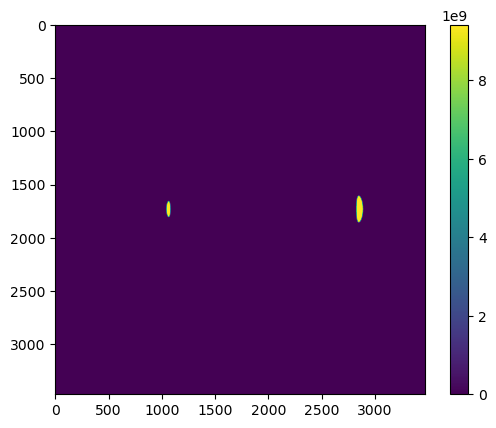

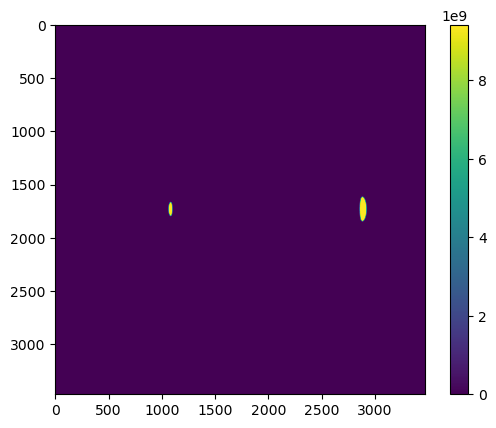

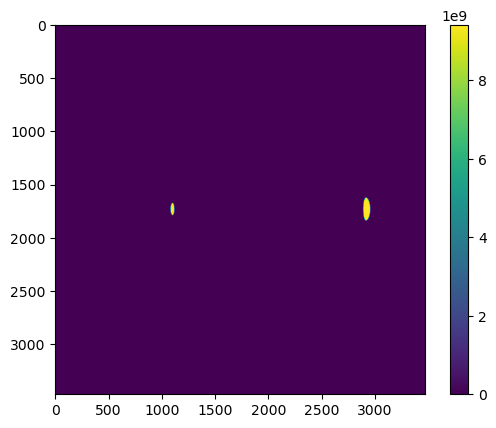

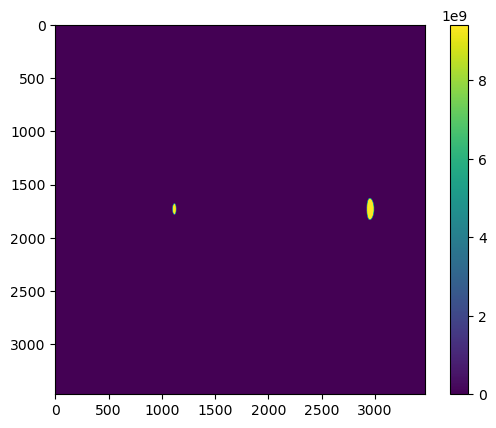

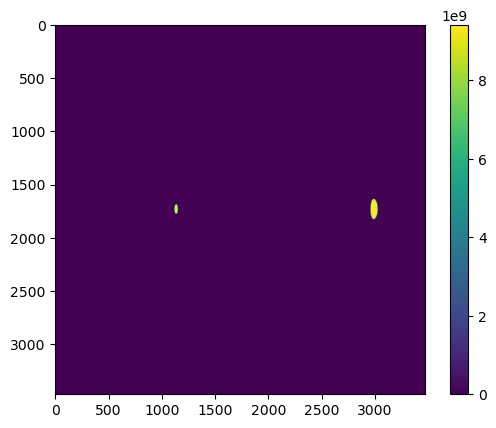

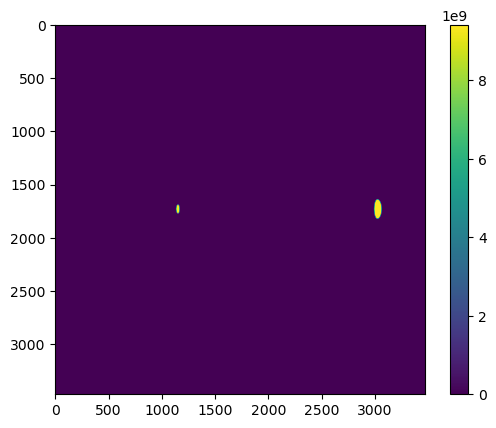

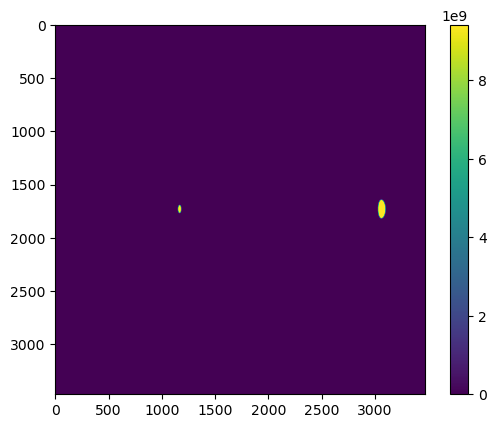

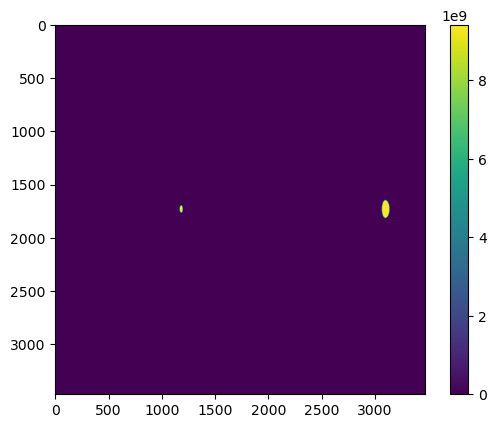

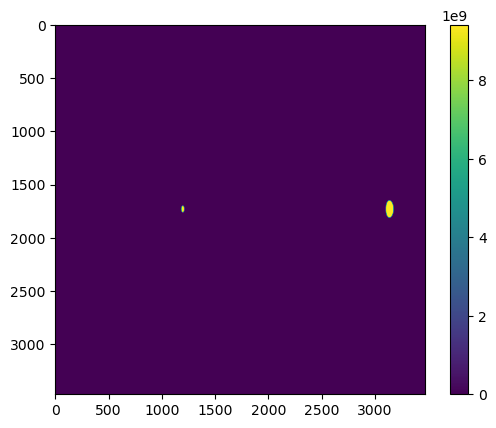

In [30]:
surface_brightnesses = []
for (x,y) in zip(tra[0], tra[1]):
    kwargs_light = [{'amp': 1, 'radius': size_s/2 * 10, 'e1': 0, 'e2': 0, 'center_x': x, 'center_y': y}]
    lensed_surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)
    lensed_image = util.array2image(lensed_surface_brightness)
    surface_brightnesses.append(np.sum(lensed_image))
    plt.imshow(lensed_image)
    plt.colorbar()
    plt.show()

In [31]:
tra[0]/theta_E

array([-2.  , -1.94, -1.88, -1.82, -1.76, -1.7 , -1.64, -1.58, -1.52,
       -1.46, -1.4 , -1.34, -1.28, -1.22, -1.16, -1.1 , -1.04, -0.98,
       -0.92, -0.86, -0.8 , -0.74, -0.68, -0.62, -0.56, -0.5 , -0.44,
       -0.38, -0.32, -0.26, -0.2 , -0.14, -0.08, -0.02,  0.04,  0.1 ,
        0.16,  0.22,  0.28,  0.34,  0.4 ,  0.46,  0.52,  0.58,  0.64,
        0.7 ,  0.76,  0.82,  0.88,  0.94,  1.  ])